# Assigment 3

## Question b - Filtered Noise

Filtered noise

In the folder “assignment-3-data” there are 32 realization (about 65 k samples each) of a filtered noisy voltage measured with a digital scope. An analog band-pass filter is used with 455 kHz center frequency and about 10 kHz, -3 dB bandwidth. Assuming stationarity and ergodicity perform the following exercises.

Can the filtered noise be still approximated by a gaussian process?
Estimate the spectral voltage density S(f) expressed in V2/Hz and the corresponding autocorrelation function R(t). Correctly normalize both the frequency and the amplitude axis.
Discuss the results and the methods used to obtain them with a few slides (max. 6 minutes per group).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data20 = pd.read_csv('./assignment-3-data/20210326-0002_20.csv',skiprows=1)

In [3]:
data20.describe()

(ms)          (mV)
count  62504.000000  62504.000000
mean       0.500024     -0.500269
std        0.288696     47.875742
min        0.000000   -108.932100
25%        0.250012    -39.142470
50%        0.500024      0.000000
75%        0.750036     37.444630
max        1.000048    108.932100

In [4]:
data30 = pd.read_csv('./assignment-3-data/20210326-0002_30.csv',skiprows=1)
data30.describe()

(ms)          (mV)
count  62504.000000  62504.000000
mean       0.500024     -0.483321
std        0.288696     47.729345
min        0.000000   -142.974900
25%        0.250012    -28.930850
50%        0.500024      0.000000
75%        0.750036     28.930850
max        1.000048    142.974900

mean, the variance and standard deviation  are similar: same value is rounded to two decimal digit. 
Data cam from 8 bit resolution ADC.

In [5]:
data20_array=  data20.loc[:,"(mV)"].T.to_numpy()
data30_array=  data30.loc[:,"(mV)"].T.to_numpy()

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2)

#time vector
time20_array = data20.loc[:,"(ms)"].T.to_numpy()

In [7]:
## Normalizing unit of measure so seconds and voltage for power calculation
time20_array_s = time20_array / 1000.0

data20_array_V = data20_array / 1000.0



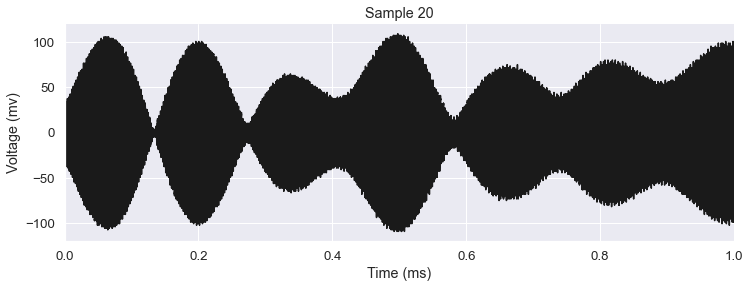

In [8]:
# Plot the signal
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(time20_array, data20_array, lw=1.5, color='k')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mv)')
plt.xlim([time20_array.min(), time20_array.max()])
plt.title('Sample 20')
sns.despine()

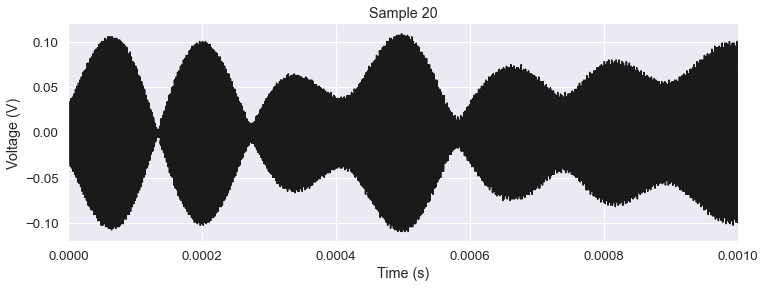

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(time20_array_s, data20_array_V, lw=1.5, color='k')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.xlim([time20_array_s.min(), time20_array_s.max()])
plt.title('Sample 20')
sns.despine()

### Sampling period esitmation

We need duration, samplig period and sampling frequency for value normalization in spectral estimation

In [10]:
duration= np.max(time20_array_s)
N_samples = time20_array.size
print("duration [s] : ",duration)

duration [s] :  0.00100004797


In [11]:
sp= duration / time20_array.size # sampling period definition
sf= 1/sp  # define sampling frequency
print("sampling period [s]: ",sp)


sampling period [s]:  1.599974353641367e-08


### Test Sampling period estimation

Sampling period must be constant for a correct power density estimation.


In [12]:
sample_intervals = []
for index in range(1,time20_array.size):
    sample_intervals.append(time20_array[index]-time20_array[index-1])

print("mean sampling interval [s] : ",np.mean(sample_intervals)/1000)
print("sampling interval standard deviation: ",np.std(sample_intervals))

mean sampling interval [s] :  1.599999952002304e-08
sampling interval standard deviation:  6.927870684160107e-11


## Power Density Estimation


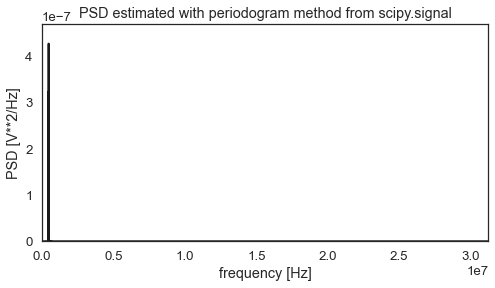

In [13]:
from scipy import signal
import matplotlib.pyplot as plt

#https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.periodogram.html
freqs, Pxx_den = signal.periodogram(data20_array_V, sf)
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs, Pxx_den, color='k', lw=2)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.ylim([0, Pxx_den.max() * 1.1])
plt.title("PSD estimated with periodogram method from scipy.signal")
plt.xlim([0, freqs.max()])
plt.show()

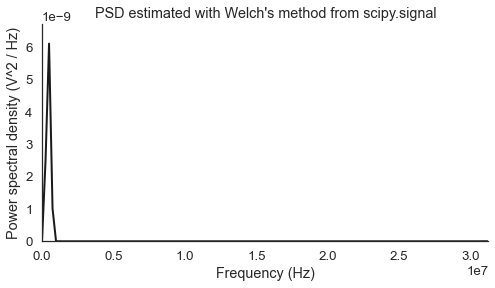

In [14]:
from scipy import signal
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html#scipy.signal.welch
freqs, welch_psd = signal.welch(data20_array_V, fs=sf,return_onesided=True,scaling='density')

# Plot the power spectrum
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs, welch_psd, color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, welch_psd.max() * 1.1])
plt.title("PSD estimated with Welch's method from scipy.signal")
plt.xlim([0, freqs.max()])
sns.despine()

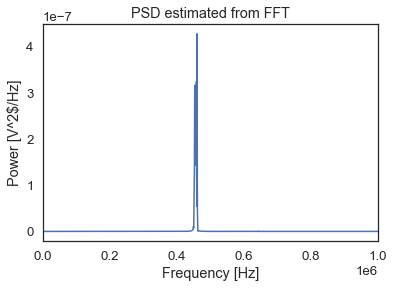

In [15]:
from scipy.fft import fft

T= duration

xf = fft(data20_array_V)       # Compute Fourier transform of x
Sxx = 2 * sp ** 2 / T * (xf * np.conj(xf)) # Compute spectrum
Sxx = Sxx[:int(len(data20_array_V) / 2)]             # Ignore negative frequencies

df = 1 / duration                  # Determine frequency resolution
fNQ = sf / 2                        # Determine Nyquist frequency
faxis = np.arange(0,fNQ,df)                # Construct frequency axis

plt.plot(faxis, np.real(Sxx))                  # Plot spectrum vs frequency
#plt.xlim([0, freqs.max()])                         # Select frequency range
plt.xlim([0, 1000000])                         # Select frequency range
plt.xlabel('Frequency [Hz]')                # Label the axes
plt.ylabel('Power [V^2$/Hz]')
plt.title("PSD estimated from FFT")
plt.show()

## Normalizzation Test

 Integral of the spectral voltage density for all frequencies is equal to the signal variance and this can also be estimated using the time sequence.



In [16]:
from scipy.integrate import simps

integral = simps(np.real(Sxx), faxis)
print("Integral of the spectral voltage density for all frequencies: ", integral)
print("Variance : ", np.var(data20_array_V))
print ("relative difference: ", integral/np.var(data20_array_V))


Integral of the spectral voltage density for all frequencies:  0.0022922569510226585
Variance :  0.0022920499574068144
relative difference:  1.0000903093822957


## Autocorrelation



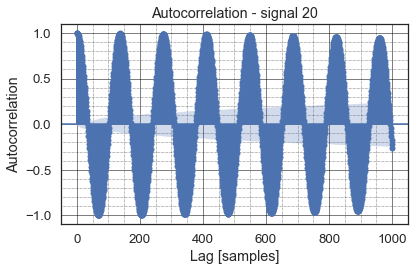

In [17]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(data20_array, lags=1000)
plt.title('Autocorrelation - signal 20')
plt.xlabel('Lag [samples]')
plt.ylabel('Autocorrelation')

plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5', color='black',zorder=0)
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black',zorder=0)

plt.tight_layout()


plt.show()

## It is Gaussian?

P(x<1): 0.509
P(x<2): 0.521
P(x<3): 0.521


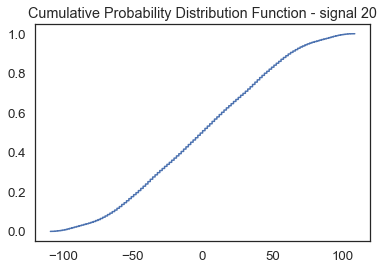

In [18]:
from statsmodels.distributions.empirical_distribution import ECDF
# https://www.statsmodels.org/stable/generated/statsmodels.distributions.empirical_distribution.ECDF.html
# fit a cdf
ecdf = ECDF(data20_array)

# get cumulative probability for values
print('P(x<1): %.3f' % ecdf(1))
print('P(x<2): %.3f' % ecdf(2))
print('P(x<3): %.3f' % ecdf(3))
plt.title('Cumulative Probability Distribution Function - signal 20')
# plot the cdf
plt.plot(ecdf.x, ecdf.y)
plt.show()


<AxesSubplot:title={'center':'empirical PDF'}, ylabel='Density'>

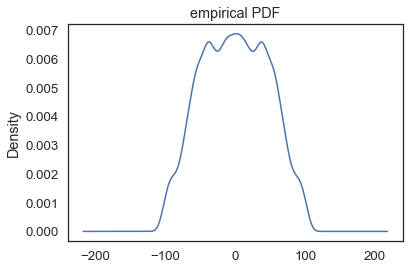

In [19]:
data20.loc[:,"(mV)"].plot(kind= 'density', title='empirical PDF')

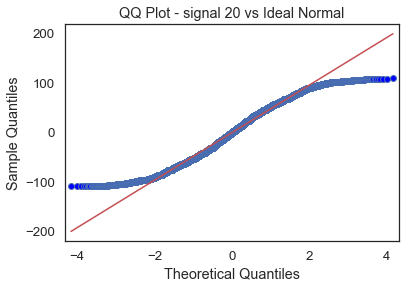

In [20]:
# QQ Plot
from numpy.random import seed
from numpy.random import randn
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot

# q-q plot
qqplot(data20_array, line='s')
pyplot.title("QQ Plot - signal 20 vs Ideal Normal")
pyplot.show()